# 04 — Sample Analysis

Generate samples from a trained checkpoint, visualize them, and compute evaluation metrics.

In [1]:
import sys
from pathlib import Path

import torch
import matplotlib.pyplot as plt

# Ensure BD_Generation is importable
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from bd_gen.data.vocab import VocabConfig, RPLAN_VOCAB_CONFIG, NODE_PAD_IDX, NODE_TYPES, EDGE_TYPES
from bd_gen.data.tokenizer import detokenize
from bd_gen.data.dataset import BubbleDiagramDataset
from bd_gen.model.denoiser import BDDenoiser
from bd_gen.diffusion.noise_schedule import get_noise
from bd_gen.diffusion.sampling import sample
from bd_gen.utils.checkpoint import load_checkpoint
from bd_gen.eval.validity import check_validity, check_validity_batch
from bd_gen.eval.metrics import (
    validity_rate, diversity, novelty, distribution_match, graph_structure_mmd,
    conditional_edge_kl, spatial_transitivity, type_conditioned_degree_kl, mode_coverage,
)
from bd_gen.viz.graph_viz import draw_bubble_diagram, draw_bubble_diagram_grid

vc = RPLAN_VOCAB_CONFIG
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


## 1. Load Checkpoint

In [2]:
# Checkpoint path (relative to PROJECT_ROOT)
CHECKPOINT_PATH = PROJECT_ROOT / "checkpoint_final.pt"

# Model config (must match training config)
model = BDDenoiser(
    d_model=128, n_layers=4, n_heads=4,
    vocab_config=vc, dropout=0.0,
).to(device)

load_checkpoint(CHECKPOINT_PATH, model, device=device)
model.eval()
print(f"Loaded checkpoint: {CHECKPOINT_PATH}")

Loaded checkpoint: c:\Users\Alessandro Zuliani\Documents\Python_projects\Davis\BD_Generation\checkpoint_final.pt


## 2. Generate Samples

In [13]:
from omegaconf import OmegaConf

noise_cfg = OmegaConf.create({"type": "linear", "sigma_min": 0.0, "sigma_max": 10.0})
noise_schedule = get_noise(noise_cfg).to(device)

# Load training set for num_rooms distribution
train_ds = BubbleDiagramDataset(
    mat_path=PROJECT_ROOT / "data" / "data.mat",
    cache_path=PROJECT_ROOT / "data_cache" / "graph2plan_nmax8.pt",
    vocab_config=vc, split="train", seed=42,
)

NUM_SAMPLES = 1000

with torch.no_grad():
    tokens = sample(
        model=model, noise_schedule=noise_schedule, vocab_config=vc,
        batch_size=NUM_SAMPLES, num_steps=100, temperature=0.0,
        num_rooms_distribution=train_ds.num_rooms_distribution,
        device=device,
    )

print(f"Generated {tokens.shape[0]} samples, shape: {tokens.shape}")

Generated 1000 samples, shape: torch.Size([1000, 36])


## 3. Visualize Samples

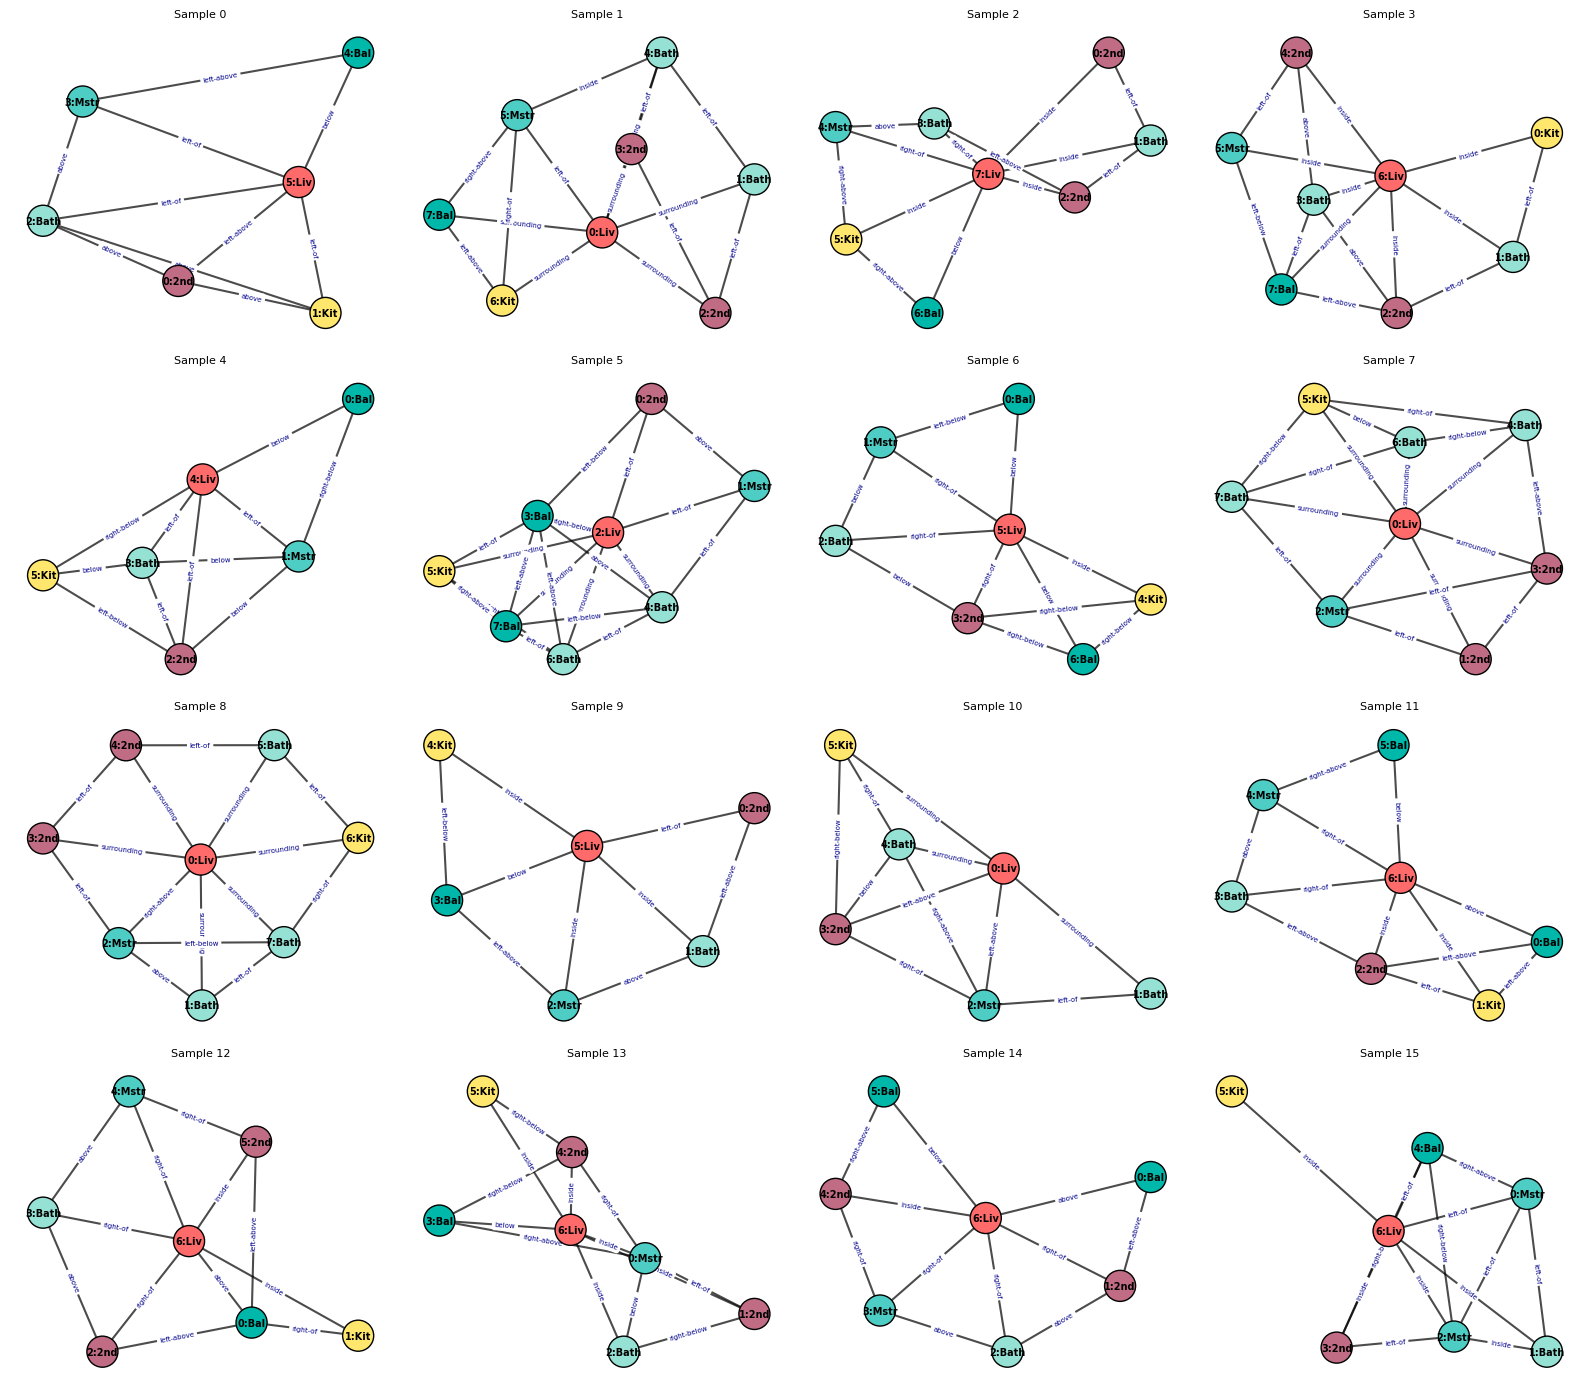

In [14]:
# Reconstruct pad masks and detokenize
graph_dicts = []
pad_masks = torch.zeros_like(tokens, dtype=torch.bool)

for i in range(tokens.size(0)):
    node_toks = tokens[i, :vc.n_max]
    nr = int((node_toks != NODE_PAD_IDX).sum().item())
    nr = max(1, min(nr, vc.n_max))
    pad_masks[i] = vc.compute_pad_mask(nr)
    try:
        gd = detokenize(tokens[i], pad_masks[i], vc)
        graph_dicts.append(gd)
    except ValueError:
        graph_dicts.append({"num_rooms": 0, "node_types": [], "edge_triples": []})

# Visualize first 16
viz_dicts = [g for g in graph_dicts[:16] if g["num_rooms"] > 0]
fig = draw_bubble_diagram_grid(viz_dicts)
plt.show()

## 4. Validity Analysis

In [15]:
results = check_validity_batch(tokens, pad_masks, vc)

v_rate = validity_rate(results)
connected_rate = sum(1 for r in results if r["connected"]) / len(results)
valid_types_rate = sum(1 for r in results if r["valid_types"]) / len(results)
no_mask_rate = sum(1 for r in results if r["no_mask_tokens"]) / len(results)

print(f"Validity rate:    {v_rate:.1%}")
print(f"Connected rate:   {connected_rate:.1%}")
print(f"Valid types rate: {valid_types_rate:.1%}")
print(f"No MASK rate:     {no_mask_rate:.1%}")

Validity rate:    99.2%
Connected rate:   100.0%
Valid types rate: 99.2%
No MASK rate:     100.0%


## 5. Quality Metrics

In [16]:
# Detokenize training set
train_dicts = []
for idx in range(min(len(train_ds), 5000)):  # Subsample for speed
    item = train_ds[idx]
    try:
        gd = detokenize(item["tokens"], item["pad_mask"], vc)
        train_dicts.append(gd)
    except ValueError:
        pass

div = diversity(graph_dicts)
nov = novelty(graph_dicts, train_dicts)
dm = distribution_match(graph_dicts, train_dicts)

print(f"Diversity: {div:.3f}")
print(f"Novelty:   {nov:.3f}")
print(f"KL divergence — nodes: {dm['node_kl']:.4f}, edges: {dm['edge_kl']:.4f}, rooms: {dm['num_rooms_kl']:.4f}")

Diversity: 0.993
Novelty:   0.995
KL divergence — nodes: 0.0499, edges: 0.2339, rooms: 0.0032


## 6. Distribution Comparison

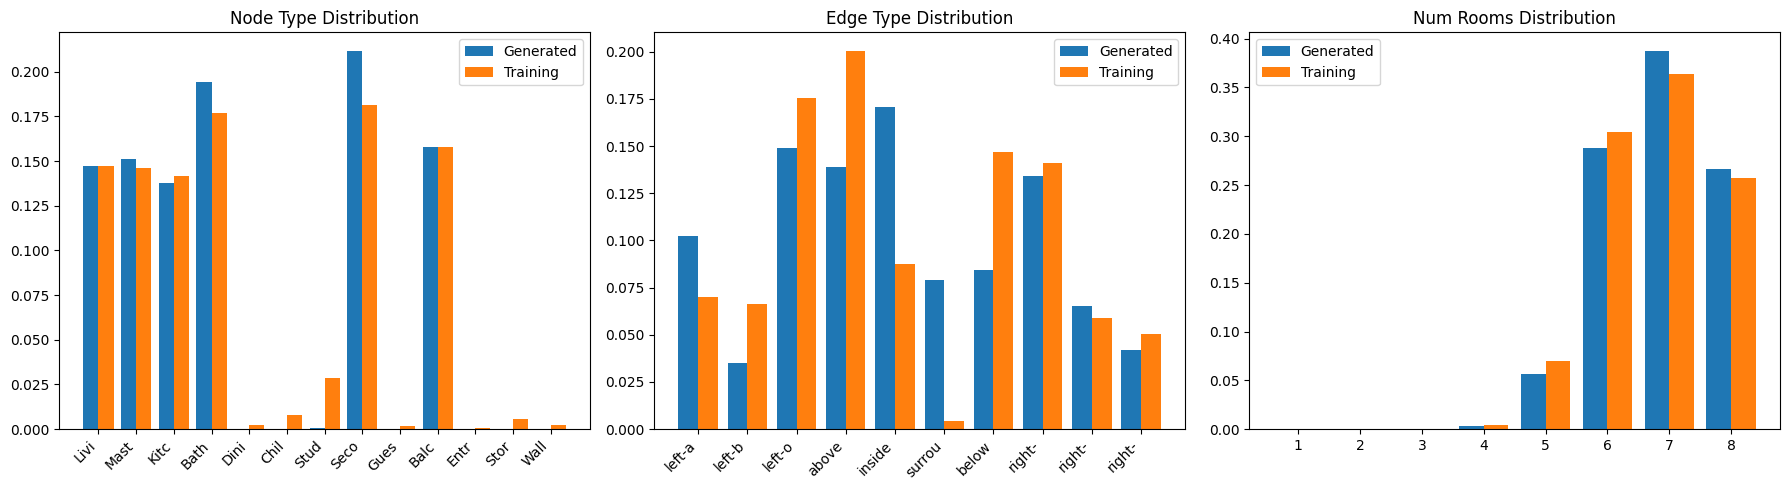

In [17]:
from collections import Counter
import numpy as np

# Node type distributions
sample_nodes = Counter(nt for g in graph_dicts for nt in g["node_types"])
train_nodes = Counter(nt for g in train_dicts for nt in g["node_types"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Node types
x = range(len(NODE_TYPES))
s_total = max(sum(sample_nodes.values()), 1)
t_total = max(sum(train_nodes.values()), 1)
axes[0].bar([i - 0.2 for i in x], [sample_nodes.get(i, 0) / s_total for i in x], 0.4, label="Generated")
axes[0].bar([i + 0.2 for i in x], [train_nodes.get(i, 0) / t_total for i in x], 0.4, label="Training")
axes[0].set_xticks(list(x))
axes[0].set_xticklabels([n[:4] for n in NODE_TYPES], rotation=45, ha="right")
axes[0].set_title("Node Type Distribution")
axes[0].legend()

# Edge types
sample_edges = Counter(rel for g in graph_dicts for _, _, rel in g["edge_triples"])
train_edges = Counter(rel for g in train_dicts for _, _, rel in g["edge_triples"])
x = range(len(EDGE_TYPES))
s_total = max(sum(sample_edges.values()), 1)
t_total = max(sum(train_edges.values()), 1)
axes[1].bar([i - 0.2 for i in x], [sample_edges.get(i, 0) / s_total for i in x], 0.4, label="Generated")
axes[1].bar([i + 0.2 for i in x], [train_edges.get(i, 0) / t_total for i in x], 0.4, label="Training")
axes[1].set_xticks(list(x))
axes[1].set_xticklabels([e[:6] for e in EDGE_TYPES], rotation=45, ha="right")
axes[1].set_title("Edge Type Distribution")
axes[1].legend()

# Num rooms
sample_rooms = Counter(g["num_rooms"] for g in graph_dicts)
train_rooms = Counter(g["num_rooms"] for g in train_dicts)
x = range(1, vc.n_max + 1)
s_total = max(sum(sample_rooms.values()), 1)
t_total = max(sum(train_rooms.values()), 1)
axes[2].bar([i - 0.2 for i in x], [sample_rooms.get(i, 0) / s_total for i in x], 0.4, label="Generated")
axes[2].bar([i + 0.2 for i in x], [train_rooms.get(i, 0) / t_total for i in x], 0.4, label="Training")
axes[2].set_xticks(list(x))
axes[2].set_title("Num Rooms Distribution")
axes[2].legend()

fig.tight_layout()
plt.show()

## 7. Graph Structure MMD

Topology-based metrics following DiGress / MELD / GraphARM evaluation protocol.

In [18]:
mmd = graph_structure_mmd(graph_dicts, train_dicts, n_max=vc.n_max)

print(f"MMD-Degree:     {mmd['mmd_degree']:.6f}")
print(f"MMD-Clustering: {mmd['mmd_clustering']:.6f}")
print(f"MMD-Spectral:   {mmd['mmd_spectral']:.6f}")
print()
print("(Lower = more similar to training set. 0 = identical distribution.)")

MMD-Degree:     0.081629
MMD-Clustering: 0.044902
MMD-Spectral:   0.004304

(Lower = more similar to training set. 0 = identical distribution.)


## 8. Conditional Edge KL

Per-room-type-pair edge distribution — catches wrong spatial relationships for specific room combinations.

In [19]:
cekl = conditional_edge_kl(graph_dicts, train_dicts, min_pair_count=5)

print(f"Conditional Edge KL (mean):     {cekl['conditional_edge_kl_mean']:.4f}")
print(f"Conditional Edge KL (weighted): {cekl['conditional_edge_kl_weighted']:.4f}")
print(f"Room-type pairs evaluated:      {int(cekl['num_pairs_evaluated'])}")
print()
print("(Lower = generated edge types better match training per room-type pair.)")

Conditional Edge KL (mean):     4.2072
Conditional Edge KL (weighted): 0.5103
Room-type pairs evaluated:      63

(Lower = generated edge types better match training per room-type pair.)


## 9. Spatial Transitivity

Detects graphs where spatial relationships form contradictory ordering cycles (physically impossible layouts).

In [20]:
st = spatial_transitivity(graph_dicts)

print(f"Spatially realizable: {st['transitivity_score']:.1%}")
print(f"H-consistent:         {st['h_consistent']:.1%}")
print(f"V-consistent:         {st['v_consistent']:.1%}")
print()
print("(Higher = more graphs have non-contradictory spatial orderings.)")

Spatially realizable: 99.1%
H-consistent:         99.7%
V-consistent:         99.4%

(Higher = more graphs have non-contradictory spatial orderings.)


## 10. Type-Conditioned Degree KL

Per-room-type node degree distribution — catches unrealistic connectivity for specific room types.

In [21]:
tcdkl = type_conditioned_degree_kl(graph_dicts, train_dicts, n_max=vc.n_max)

print(f"Per-type degree KL (mean):     {tcdkl['degree_kl_per_type_mean']:.4f}")
print(f"Per-type degree KL (weighted): {tcdkl['degree_kl_per_type_weighted']:.4f}")
print(f"Room types evaluated:          {int(tcdkl['num_types_evaluated'])}")
print()
print("(Lower = per-room-type connectivity better matches training.)")

Per-type degree KL (mean):     4.1563
Per-type degree KL (weighted): 0.3876
Room types evaluated:          13

(Lower = per-room-type connectivity better matches training.)


## 11. Mode Coverage

Measures what fraction of training room-type archetypes the model reproduces — detects mode collapse.

In [22]:
mc = mode_coverage(graph_dicts, train_dicts)

print(f"Mode coverage:            {mc['mode_coverage']:.1%}")
print(f"Mode coverage (weighted): {mc['mode_coverage_weighted']:.1%}")
print(f"Training archetypes:      {int(mc['num_training_modes'])}")
print(f"Sample archetypes:        {int(mc['num_sample_modes'])}")
print()
print("(Higher = model reproduces more of the training set's room-type compositions.)")

Mode coverage:            18.4%
Mode coverage (weighted): 74.9%
Training archetypes:      266
Sample archetypes:        74

(Higher = model reproduces more of the training set's room-type compositions.)
